In [1]:
import math as mt
import numpy as np
import sympy as smp
from sympy.physics.mechanics import *
from scipy.integrate import odeint
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import animation
from matplotlib.animation import PillowWriter
from IPython.display import HTML

import time
from tqdm import tqdm
import json

from scipy.integrate import ode
from scipy.integrate import solve_ivp
import matplotlib.gridspec as gridspec
from mplcursors import cursor
from scipy.interpolate import make_interp_spline

import pyperclip as clip

## Ellipsoid

### Symbols

t, g, m, R, $\theta$:

In [2]:
t, g, m, R = smp.symbols('t g m R')
theta, thetadot, thetaddot = smp.symbols('theta thetadot thetaddot')

$x(t)$, $y(t)$ and $z(t)$:

In [3]:
x, y, z =  smp.symbols('x y z', cls=smp.Function)
xdot, xddot, ydot, yddot, zdot, zddot = smp.symbols('xdot xddot ydot yddot zdot zddot', cls=smp.Function)
x = x(t)
y = y(t)
z = z(t)
xdot = smp.diff(x, t) 
ydot = smp.diff(y, t)
zdot = smp.diff(z, t)
xddot = smp.diff(xdot, t)
yddot = smp.diff(ydot, t)
zddot = smp.diff(zdot, t)

$\alpha(t)$, $\beta(t)$ and $\gamma(t)$

In [4]:
alpha, beta, gamma = smp.symbols('alpha beta gamma', cls=smp.Function)
alphadot, alphaddot, betadot, betaddot, gammadot, gammaddot = smp.symbols('alphadot alphaddot betadot betaddot gammadot gammaddot', cls=smp.Function)
alpha = alpha(t)
beta  = beta(t)
gamma = gamma(t)
alphadot = smp.diff(alpha, t)     # alpha_d
betadot = smp.diff(beta, t)       # beta_d
gammadot = smp.diff(gamma, t)     # gamma_d
alphaddot = smp.diff(alphadot, t) # alpha_dd
betaddot = smp.diff(betadot, t)   # beta_dd
gammaddot = smp.diff(gammadot, t) # gamma_dd

### Initialization Variables
[Ellipsoid]

In [5]:
# Court variables (m)
court_length = 23.77 
doubles_court_width = 10.97 
singles_court_width = 8.23 
net_height_middle = 0.915 
net_height_sides = 1.065 

# Ball
mg_b = 58.3                  #ball mass in g
mkg_b = mg_b / 1000          #ball mass in kg
dcm_b = 6.5                  #ball diameter in cm
rm_b = (dcm_b/2)/100         #ball radius in m

# Ellipsoid values with radius: a, b, c and with Volume of 143.8 cm^3, assuming a forward deformation of 6mm and return deformation of 8mm
# (Volume for a tennis ball with 6.5cm diameter - 4/3 * pi * r^3 = 143.8 cm^3)
a, b, c = smp.symbols('a b c')
# Oblate
ellipsoid_a_cm = 3.066
ellipsoid_b_cm = 3.65
ellipsoid_c_cm = 3.066

# Game
avg_dist_cp = 0.95           #average distance from impact point to the ground in m
a_gravity = 9.8              #gravity accerelation in m/s^2
ct_s = 1/200                 #contact time with the racket in seconds <=> 0.005s
init_vel_known = 0           #known initial velocity of the ball, normally 17 m/s, (limited to 28 m/s)
init_f_known = 0             #known initial force of the hit, considered normally to be 200N if initial velocity is unknown (= 0)           
init_theta_known = 0         #known initial angle of the hit, normally 18º
in_psi_ = 50                 #known initial angle of spin, normally 50º. Valid if spin_type is "Slice" or "Topspin"

# Parameters
rho = 1.2                    #density of the air in kg/m^3 
A = smp.pi*rm_b**2           #cross sectional area of the ball in m^2
Cd = 0.53                    #drag coefficient of the spherical ball considered (based on research articles)
Cl = 0.2                     #lift coefficient of the spherical ball considered (based on research articles)
spin_type = 0                #spin type of the ball: "0->None/Flat hit", "1->Topspin" or "2->Slice"

# Initial contact point based on the initial angles of impact
ctc_pt = (init_theta_known, in_psi_) 

### Initial functions

In [6]:
def calc_f_init_with_v(vi, vf, delta_t):
    """From the initial and final velocities of the ball, calculates the force applied to the ball"""
    a = (vf-vi)/delta_t
    F = (mg_b/1000)*a
    return F

In [7]:
def calc_v_init_with_f(F, delta_t):
    """From the force applied to the ball, it calculates the initial velocity of the ball"""
    a = F/(mg_b/1000)
    v = a*delta_t
    return round(v,2)

### Spin analysis

In [8]:
match spin_type:
    case 0: #None
        psi_= 0
        lift_sign_up = False
        
    case 1: #Topspin
        # Cross product result: downward lift force (Fy positive)
        psi_ = ctc_pt[1]          
        lift_sign_up = False
        betadot = betadot
        #alphadot = alphadot
        
    case 2: #Slice
        # Cross product result: upward lift force (Fy negative)
        psi_ = -ctc_pt[1]         
        lift_sign_up = True
        betadot = -betadot
        #alphadot = -alphadot
        

### Forces & Torque

Notes:
- N - Initial binary (external torque, rotation)
- N computation with impact force applied
- When N its equal to 0 the system is in equilibrium
- Afetrwards, N incorporated into all the lagrangian equations, making the system of differential equations affected by it

In [9]:
if spin_type == 0:
    N = 0
    psi = int(mt.radians(psi_))
    print("No spin. (N =", N, "N.m)")
    
    v_init = 0
    if init_vel_known != 0:
        if init_theta_known != 0:
            if init_f_known != 0:
                F = init_f_known
                print("Initial force: ", init_f_known, "Newtons")
            else:
                F = calc_f_init_with_v(0,init_vel_known,ct_s)
                print("Force initially unknown")
            print("Initial angle:", init_theta_known, "º")
        else:
            if init_f_known != 0:
                F = init_f_known
                print("Initial force: ", init_f_known, "Newtons")
            else:
                F = calc_f_init_with_v(0,init_vel_known,ct_s)
                print("Force initially unknown")
            print("Initial angle unkonwn")
            
        if init_f_known == 0:
            print("Initial velocity:", init_vel_known, "m/s. Creates a Force of", F, "N in", ct_s, "s")
        else:
            print("Initial velocity:", init_vel_known, "m/s")
        
    else:
        print("Velocity initially unkonwn")
        if init_theta_known != 0:
            if init_f_known != 0: 
                F = init_f_known
                v_init = calc_v_init_with_f(F,ct_s)
                print("Initial force: ", init_f_known, "N. Creates a initial velocity of", v_init, "m/s in ", ct_s, "s")
            else:
                print("Force unknown")
            print("Initial angle:", init_theta_known, "º")
        else:
            if init_f_known != 0: 
                F = init_f_known
                v_init = calc_v_init_with_f(F,ct_s)
                print("Initial force: ", init_f_known, "N. Creates a initial velocity of", v_init, "m/s in ", ct_s, "s")
            else:
                print("Force unknown")
            print("Initial angle unkonwn")
        
    
elif spin_type == 1 or spin_type == 2:
    if in_psi_ == 0 or (init_vel_known == 0 and init_f_known == 0):
        print("Invalid input. Please provide a valid initial velocity or force and a valid spin angle | [Valid values > 0]")
    else:
        # The racket hit with an angle making a psi angle after for the spin 
        psi = mt.radians(psi_)                            #spin_ang

        # Force (needed to create spin)
        if init_vel_known != 0:                           #if the initial velocity is known
            F = calc_f_init_with_v(0,init_vel_known,ct_s) #computes Force from velocity
            print("Initial velocity:", init_vel_known, "m/s")
        elif init_vel_known == 0:                         #if the initial velocity is unknown
            F = init_f_known                              #Known force                             
            v_init = calc_v_init_with_f(F,ct_s)           #computes velocity in respect to the force applied 
            print("Initial velocity:", v_init, "m/s")
            
        print("F:", F, "Newtons")


        # Axis forces
        Fx = round(F*mt.cos(psi),2)                       #responsible for the linear component
        Fy = round(F*mt.sin(psi),2)                       #responsible for the spin
        print("Fx:", Fx, "Newtons")
        print("Fy:", Fy, "Newtons")


        # Torque
        N = int(rm_b*Fy)                                  #torque from the force applied 
        print("N:", N, "N.m")
    
else:
    print("Invalid spin type")

No spin. (N = 0 N.m)
Velocity initially unkonwn
Force unknown
Initial angle unkonwn


## Kinetic energy (T) and Potential energy (U)

- Assumption: The forces are applied on the center of mass [COM] 
- Off-diagonal elements are slight asymmetries in the mass distribution (example: $1e^{-6}$ $kg·m^2$)

In [10]:
# Moments of inertia
Ixx = smp.Rational(1,5) * m * (b**2 + c**2)
Iyy = smp.Rational(1,5) * m * (a**2 + c**2)	
Izz = smp.Rational(1,5) * m * (a**2 + b**2)

# Off-diagonal elements
Ixy = Iyx = 0
Ixz = Izx = 0
Iyz = Izy = 0
I = smp.Matrix([
        [Ixx, Ixy, Ixz],
        [Iyx, Iyy, Iyz],
        [Izx, Izy, Izz]
    ])
I

Matrix([
[m*(b**2 + c**2)/5,                 0,                 0],
[                0, m*(a**2 + c**2)/5,                 0],
[                0,                 0, m*(a**2 + b**2)/5]])

In [11]:
omega   = smp.Matrix([alphadot, betadot, gammadot]) #angular velocity vector
upsilon = smp.Matrix([xdot, ydot, zdot])            #velocity vector
epsilon = smp.Matrix([x, y, z])                     #position vector

upsilon_squared = upsilon.dot(upsilon)              #squared norm, same as (xdot^2 + ydot^2 + zdot^2)

### Aerodynamic disturbances

Drag Force

In [12]:
Fd = -smp.Rational(1,2)*rho*A*Cd*upsilon_squared.simplify()
Fd

-0.0003358875*pi*(Derivative(x(t), t)**2 + Derivative(y(t), t)**2 + Derivative(z(t), t)**2)

Lift Force (using Magnus effect)

Scaled and with direction where: 
- 1st row  - x-component of the lift force
- 2nd row  - y-component of the lift force
- 3rd row  - z-component of the lift force

In [13]:
Fl_magn = smp.Rational(1,2)*rho*A*Cl*upsilon_squared.simplify()     #lift force magnitude
Fl_dire = omega.cross(upsilon)                                      #lift force direction
Fl = Fl_magn * Fl_dire 
Fl

Matrix([
[  0.00012675*pi*(Derivative(beta(t), t)*Derivative(z(t), t) - Derivative(gamma(t), t)*Derivative(y(t), t))*(Derivative(x(t), t)**2 + Derivative(y(t), t)**2 + Derivative(z(t), t)**2)],
[0.00012675*pi*(-Derivative(alpha(t), t)*Derivative(z(t), t) + Derivative(gamma(t), t)*Derivative(x(t), t))*(Derivative(x(t), t)**2 + Derivative(y(t), t)**2 + Derivative(z(t), t)**2)],
[  0.00012675*pi*(Derivative(alpha(t), t)*Derivative(y(t), t) - Derivative(beta(t), t)*Derivative(x(t), t))*(Derivative(x(t), t)**2 + Derivative(y(t), t)**2 + Derivative(z(t), t)**2)]])

Total aerodynamic disturbance forces
- There is no lift force if the ball has no spin ($N = 0 => Fl = 0$)

In [14]:
if N == 0: 
    #T3 = Fd #With drag
    T3 = 0 #Without drag 
else:
    T3 = smp.Matrix([Fd, Fd, Fd]) + Fl
    T3 = T3.dot(upsilon) 
T3

0

### Kinetic energy (T)

In [15]:
T1 = smp.Rational(1,2)*m*upsilon_squared.simplify()         #translational motion
T2 = smp.Rational(1,2)*(omega.T*I*omega)[0].simplify()      #rotational motion 
T = T1 + T2 + T3                                            #sum with the airodinamic disturbances
T

m*((a**2 + b**2)*Derivative(gamma(t), t)**2 + (a**2 + c**2)*Derivative(beta(t), t)**2 + (b**2 + c**2)*Derivative(alpha(t), t)**2)/10 + m*(Derivative(x(t), t)**2 + Derivative(y(t), t)**2 + Derivative(z(t), t)**2)/2

### Potential energy (U)

In [16]:
U = m*g*z
U

g*m*z(t)

### Lagrangian (L)

In [17]:
L = T - U
L

-g*m*z(t) + m*((a**2 + b**2)*Derivative(gamma(t), t)**2 + (a**2 + c**2)*Derivative(beta(t), t)**2 + (b**2 + c**2)*Derivative(alpha(t), t)**2)/10 + m*(Derivative(x(t), t)**2 + Derivative(y(t), t)**2 + Derivative(z(t), t)**2)/2

### Get Lagrange's equations for each free variable

 
$\frac{d}{dt}\frac{\partial L}{\partial \dot{x}} - \frac{\partial L}{\partial x} = 0$ 

$\frac{d}{dt}\frac{\partial L}{\partial \dot{y}} - \frac{\partial L}{\partial y} = 0$ 

$\frac{d}{dt}\frac{\partial L}{\partial \dot{z}} - \frac{\partial L}{\partial z} = 0$

$\frac{d}{dt}\frac{\partial L}{\partial \dot{\alpha}} - \frac{\partial L}{\partial \alpha} = 0$

$\frac{d}{dt}\frac{\partial L}{\partial \dot{\beta}} - \frac{\partial L}{\partial \beta} = 0$

$\frac{d}{dt}\frac{\partial L}{\partial \dot{\gamma}} - \frac{\partial L}{\partial \gamma} = 0$

This later equations (=0) show that the system is conservative meaning there are no non-conservative forces (like friction or external forces) acting on the system.

In [18]:
LEx = smp.diff(smp.diff(L, xdot), t).simplify() - smp.diff(L, x) 
LEx

m*Derivative(x(t), (t, 2))

In [19]:
LEy = smp.diff(smp.diff(L, ydot), t).simplify() - smp.diff(L, y)
LEy

m*Derivative(y(t), (t, 2))

In [20]:
LEz = smp.diff(smp.diff(L, zdot), t).simplify() - smp.diff(L, z)
LEz

g*m + m*Derivative(z(t), (t, 2))

In [21]:
LEalpha = smp.diff(smp.diff(L, alphadot), t).simplify() - smp.diff(L, alpha)
LEalpha

m*(b**2 + c**2)*Derivative(alpha(t), (t, 2))/5

In [22]:
#If its a slice: betadot is negative and can't be negative for this computation
#It needs to be positive and then turn back to negative afterwards
if lift_sign_up:
    LEbeta = smp.diff(smp.diff(L, -betadot), t).simplify() - smp.diff(L, beta)
    LEbeta = LEbeta.subs(smp.diff(smp.diff(beta, t), t), smp.diff(betadot, t))
else: 
    LEbeta = smp.diff(smp.diff(L, betadot), t).simplify() - smp.diff(L, beta)
LEbeta

m*(a**2 + c**2)*Derivative(beta(t), (t, 2))/5

In [23]:
LEgamma = smp.diff(smp.diff(L, gammadot), t).simplify() - smp.diff(L, gamma)
LEgamma

m*(a**2 + b**2)*Derivative(gamma(t), (t, 2))/5

#### Solve Lagranges equations (assuming that all `LE`'s are equal to N)

- When $N = 0$ these equations are linear in $\ddot{x}, \ddot{y}, \ddot{z}, \ddot{\alpha}, \ddot{\beta}, \ddot{\gamma}$. (Giving: 6 unkowns, 6 equations, 6 linear equations)
- When $N \neq 0$ some of these equations become nonlinear in their respective free variable, since is multiplied by other time derivatives

In [24]:
sols = smp.solve([smp.Eq(LEx, N), smp.Eq(LEy, N), smp.Eq(LEz, N), smp.Eq(LEalpha, N), smp.Eq(LEbeta, N), smp.Eq(LEgamma, N)], (xddot, yddot, zddot, alphaddot, betaddot, gammaddot), simplyfy=False, rational=False)

In [25]:
sols_xddot = smp.simplify(sols[xddot])
sols_xddot = smp.nsimplify(sols_xddot)

In [26]:
sols_yddot = smp.simplify(sols[yddot])
sols_yddot = smp.nsimplify(sols_yddot)

In [27]:
sols_zddot = smp.simplify(sols[zddot])
sols_zddot = smp.nsimplify(sols_zddot)

In [28]:
sols_alphaddot = smp.simplify(sols[alphaddot])
sols_alphaddot = smp.nsimplify(sols_alphaddot)

In [29]:
sols_betaddot = smp.simplify(sols[betaddot])
sols_betaddot = smp.nsimplify(sols_betaddot)

In [30]:
sols_gammaddot = smp.simplify(sols[gammaddot])
sols_gammaddot = smp.nsimplify(sols_gammaddot)

Now I have: 

$\frac{d^2 x}{dt^2} = ...$

$\frac{d^2 y}{dt^2} = ...$

$\frac{d^2 z}{dt^2} = ...$

$\frac{d^2 \alpha}{dt^2} = ...$

$\frac{d^2 \beta}{dt^2} = ...$

$\frac{d^2 \gamma}{dt^2} = ...$

(explicity in terms of second derivatives)

Which are 6 second order ODEs

Convert to first order, example: 

1. Define $b_x = \frac{dx}{dt}$
2. Then $\frac{db_x}{dt} = \frac{d^2x}{dt^2}$

Now I get a system of 12 first order ODEs:

* $\frac{db_x}{dt} = ...$ 
* $\frac{dx}{dt} = b_x $ 

* $\frac{db_y}{dt} = ...$ 
* $\frac{dy}{dt} = b_y $ 

* $\frac{db_z}{dt} = ...$ 
* $\frac{dz}{dt} = b_z $

* $\frac{db_\alpha}{dt} = ...$ 
* $\frac{d\alpha}{dt} = b_\alpha $  

* $\frac{db_\beta}{dt} = ...$ 
* $\frac{d\beta}{dt} = b_\beta $ 

* $\frac{db_\gamma}{dt} = ...$ 
* $\frac{d\gamma}{dt} = b_\gamma $ 

Convert the **symbolic** expressions above to numerical functions so I can use them in a **numerical** python solver. For this we use `smp.lambdify`

### First order ODE's (python numerical functions):

In [31]:
dbxdt_f = smp.lambdify((t,g,m,a,b,c,xdot,ydot,zdot,alphadot,betadot,gammadot), sols_xddot) 
dxdt_f = smp.lambdify(xdot, xdot)

In [32]:
dbydt_f = smp.lambdify((t,g,m,a,b,c,xdot,ydot,zdot,alphadot,betadot,gammadot), sols_yddot) 
dydt_f = smp.lambdify(ydot, ydot)

In [33]:
dbzdt_f = smp.lambdify((t,g,m,a,b,c,xdot,ydot,zdot,alphadot,betadot,gammadot), sols_zddot) 
dzdt_f = smp.lambdify(zdot, zdot)

In [34]:
dbalphadt_f = smp.lambdify((t,g,m,a,b,c,xdot,ydot,zdot,alphadot,betadot,gammadot), sols_alphaddot) 
dalphadt_f = smp.lambdify(alphadot, alphadot)

In [35]:
dbbetadt_f = smp.lambdify((t,g,m,a,b,c,xdot,ydot,zdot,alphadot,betadot,gammadot), sols_betaddot) 
dbetadt_f = smp.lambdify(betadot, betadot)

In [36]:
dbgammadt_f = smp.lambdify((t,g,m,a,b,c,xdot,ydot,zdot,alphadot,betadot,gammadot), sols_gammaddot) 
dgammadt_f = smp.lambdify(gammadot, gammadot)

## Functions

There are 12 "things" I want to solve: ($x$, $b_x$, $y$, $b_y$, $z$, $b_z$, $\alpha$, $b_\alpha$, $\beta$, $b_\beta$, $\gamma$, $b_\gamma$)

Now I define state solver vector $\vec{S} = (x, b_x, y, b_y, z, b_z, \alpha, b_\alpha, \beta, b_\beta, \gamma, b_\gamma)$. 

If I'm going to use an ODE solver in python, I need to write a function that takes in $\vec{S}$ and $t$ and returns $d\vec{S}/dt$. In other words, I need to define $d\vec{S}/dt (\vec{S}, t)$

- The system of ODEs can be fully specified using  $d\vec{S}/dt$ and depends only on  $\vec{S}$ and $t$
- Function of $S$ and $t$ that is the differential equation that describes the system
- It takes parameters of the system

Returns: $\frac{ds}{dt} = [\frac{dx}{dt}, \frac{db_x}{dt}, \frac{dy}{dt}, \frac{db_y}{dt}, \frac{dz}{dt}, \frac{db_z}{dt}, \frac{d\alpha}{dt}, \frac{db_\alpha}{dt}, \frac{d\beta}{dt}, \frac{db_\beta}{dt}, \frac{d\gamma}{dt}, \frac{db_\gamma}{dt}]$

In [37]:
def dSdt(S, t, g, m, a,b,c):
    x, bx, y, by, z, bz, alpha, balpha, beta, bbeta, gamma, bgamma = S
    return [
        dxdt_f(bx),
        dbxdt_f(t,g,m,a,b,c,bx,by,bz,balpha,bbeta,bgamma),
        dydt_f(by),
        dbydt_f(t,g,m,a,b,c,bx,by,bz,balpha,bbeta,bgamma),
        dzdt_f(bz),
        dbzdt_f(t,g,m,a,b,c,bx,by,bz,balpha,bbeta,bgamma),
        dalphadt_f(balpha),
        dbalphadt_f(t,g,m,a,b,c,bx,by,bz,balpha,bbeta,bgamma),
        dbetadt_f(bbeta),
        dbbetadt_f(t,g,m,a,b,c,bx,by,bz,balpha,bbeta,bgamma),
        dgammadt_f(bgamma),
        dbgammadt_f(t,g,m,a,b,c,bx,by,bz,balpha,bbeta,bgamma),
    ]

Court validation function : `IN` | `OUT` 

In [38]:
def check_court(_x, _y, _z):
    if max(_x) >= (court_length/2):
        if max(_x) <= court_length:
            if max(_y) <= (singles_court_width/2) and min(_y) >= -(singles_court_width/2):
                i=0
                flag = False
                while i < len(_x):
                    if _x[i] >= (court_length/2):
                        if flag == False:
                            if _z[i] > net_height_middle and i != 0:
                                flag = True
                                #IN: the ball did go over the net 
                            else: 
                                return False
                                #OUT: the ball didn't go over the net
                        else:
                            if (_y[i] <= (singles_court_width/2) and _y[i] >= -(singles_court_width/2)) and _x[i] <= court_length: 
                                return True
                                #IN: the ball is in the limits of the court
                            else: 
                                return False
                                #OUT: the ball is out the limits of the court
                    i += 1
            else: 
                return False
                #OUT: the ball is out the limits of the court
        else:
            return False
            #OUT: the ball is out the limits of the court
    else:
        return False
        #OUT: the ball didn't surpass the net

Function that checks the ball when it hits the ground
- when it does: cut the list after that point and make xmax

In [39]:
def check_ball_ground(f_results_g):
    res_above_ground_values = []
    i = 0
    
    for f_result_g in tqdm(f_results_g):
        z_res = f_result_g[3].T[4]
        z_n_res = [g for g in z_res if g>=0] 
        lz_res = len(z_n_res)
        f_result_g[3] = f_result_g[3][:lz_res]  #all values above the ground
        
        flag_g = False
        while i < len(f_result_g[3].T[0]):      #x
            if f_result_g[3].T[0][i] >= (court_length/2):
                if flag_g == False:
                    if z_n_res[i] > net_height_middle and i != 0:  #z at the net
                        flag_g = True
                        print("Over the net at *real* y=", round(f_result_g[3].T[0][i], 3), "with z=", round(z_n_res[i], 3), "m") #x simul at the net
                        #IN: the ball did go over the net 
                    else: 
                        f_result_g[3].T[0][i] = (court_length/2)   #Xmax is the Xnet 
                        #OUT: the ball didn't go over the net
                else:
                    pass
            else:
                pass
            i+=1
            
        res_above_ground_values.append(f_result_g)
    
    return res_above_ground_values
        

Compute the angle $\phi$ from a point in the court to another 

In [40]:
def compute_phi(p1, p2):
    #p1 = [x1,y1], p2 = [x2,y2]
    c_opt = abs(p2[1]-p1[1])
    c_adj = abs(p2[0]-p1[0])
    phi_ = mt.degrees(mt.atan((c_opt)/(c_adj)))
    if (p2[1]-p1[1]) < 0:
        phi_ = phi_ * -1
    else:
        phi_ = phi_ * 1
        
    if phi_ == -0.0:
        phi_ = 0.0
    
    return phi_

Find **f_results** matrix

- from an initial point $p_0$
- $\phi$ can vary or not
- initial contact height $z_0$
- $v_0$ from $1$ to $28$ m/s
- $\theta$ from $1$ to $89$ degrees 
- f_results is the list to store all the function results
- computes all the possibilities inside the values
- solves the system of ODEs using scipys `odeint` method

Returns: $f_{results} = [v_0, \theta, \phi, f, F]$

Where $f.T = [x, v_{0x}, y, v_{0y}, z, v_{0z}, \alpha, \omega _{0x}, \beta, \omega _{0y}, \gamma, \omega _{0z}]$

In [41]:
def calc_f_results(p0, phi_list, z0=0.95, v0_list=range(1,28), theta_list=range(1,90)):
    f_results = []          
    
    for v0_ in tqdm(v0_list):
        for theta_ in theta_list:
            for phi_ in phi_list:
                neg = False
                init_magn_force_ = round(calc_f_init_with_v(0,v0_,ct_s))
                data = [v0_, theta_, phi_]
                #Mirror the phi, it doesn't matter if it's negative or positive for Vx
                if phi_ < 0: 
                    phi_ = phi_ * -1 
                    p0[1] = p0[1] * -1
                    neg = True
                v0x_ = v0_ * mt.cos(mt.radians(theta_))*mt.cos(mt.radians(phi_))
                v0y_ = v0_ * mt.cos(mt.radians(theta_))*mt.sin(mt.radians(phi_))
                v0z_ = v0_ * mt.sin(mt.radians(theta_))                
                w0x_ = v0x_/a
                w0y_ = v0y_/b
                w0z_ = v0z_/c
                init = [p0[0], v0x_, p0[1], v0y_, z0, v0z_, 0, w0x_, 0, w0y_, 0, w0z_]
            
                odeint.mxstep = 50000000
                f_result = odeint(dSdt, y0=init, t=t, args=(g, m, a, b, c))
                
                #Make all the y and vy values negative again, return the phi to the original value
                if neg:     
                    phi_ = phi_ * -1
                    p0[1] = p0[1] * -1
                    f_result[:,2] = f_result[:,2] * -1
                    f_result[:,3] = f_result[:,3] * -1
                data.append(f_result)     
                data.append(init_magn_force_)           
                f_results.append(data)
  
            time.sleep(0.02)
    return f_results

`IN` Results function

- Checks if the values computed and in `f_results` are inside the court and valid or not
- Uses `check_court[]` function to check if the ball is in the court or not

In [42]:
def in_results(f_results):
    checked_results = []
    count_in = 0
    len_results = len(f_results)

    for f_result in tqdm(f_results):
    
        v0_ = f_result[0]
        theta_ = f_result[1]
        phi_ = f_result[2]
        x_ = f_result[3].T[0]
        y_ = f_result[3].T[2]
        z_ = f_result[3].T[4]
            
        #Cut the lists to the same length of the z list (above the ground 0)
        #Replace the list of coordinates with the lists above the ground 0
        z_n_=[h for h in z_ if h>=0]
        lz_ = len(z_n_)
        f_result[3] = f_result[3][:lz_]
        x_n_ = f_result[3].T[0]
        y_n_ = f_result[3].T[2]

        if check_court(x_n_, y_n_, z_n_) != False:
            count_in += 1
            checked_results.append(f_result)
            
    print("Total number of results IN:", count_in)
    percentage_in = (count_in * 100) / len_results
    print("Percentage of results IN:", percentage_in, "%")
    
    return checked_results

Min error and compute error functions

$min || x_{max} - x ||^2$

In [43]:
def norm_error(x_real, x_pred, y_real, y_pred):
    error = np.linalg.norm(x_real - x_pred)**2 + np.linalg.norm(y_real - y_pred)**2
    return error

Compute errors ($e$) using `norm_error` and add them to the checked `f_results` matrix resulting in: $f_{results} = [v_0, \theta, \phi, f, F,e]$

In [44]:
def compute_errors(checked_results, desire_values):
    error_results = []
    checked_err_results = checked_results.copy()

    x_real = desire_values[0]
    y_real = desire_values[1]

    for result in checked_results:
        x_chk = result[3].T[0]
        y_chk = result[3].T[2]
        x_max_pred = max(x_chk)
        if min (y_chk) < 0:
            y_max_pred = min(y_chk)
        else:
            y_max_pred = max(y_chk)
        # Ymax - y_max_pred | Xmax - x_max_pred | Yreal - y_real | Xreal - x_real

        error = norm_error(x_real, x_max_pred, y_real, y_max_pred)
        result_index = checked_results.index(result)
        checked_err_results[result_index].append(error)
        error_results.append(error)
    
    return error_results, checked_err_results

Computes the Euclidean distance between two points, normally the origin and final

In [45]:
def distance_bt_two_points(p1, p2):
   # p1[x1,y1] p2[x2,y2]
   d = mt.sqrt((p2[0]-p1[0])**2 + (p2[1]-p1[1])**2)
   return d

In [46]:
def cal_delta_from_coord(i_1, i_2, time_step_i):
    """Euclidean value between two values divided by the time step"""
    delta = round(((i_2 - i_1) / time_step_i),3)
    return delta

In [47]:
def compute_time_results(i_time, time_step_i, i_0=None, is_velocity=False):
    """Similar to np.gradient() function that handles the differentiation"""
    vector_i = [0]
    if is_velocity:
        NUM = 1
    elif not is_velocity:
        NUM = 0
            
    if i_0 is not None:
        vector_i.append(i_0)
    
    if i_time is not None:
        if np.all(i_time == 0):
            return i_time
        else:
            for i in range(NUM, len(i_time)-1):
                i_now = i_time[i]
                i_after = i_time[i+1]
                i_result = cal_delta_from_coord(i_now, i_after, time_step_i)
                vector_i.append(i_result)
            return vector_i
            
    vector_i.clear()

In [48]:
def calc_force_from_a(a_time, m=m):
    """From the acceleration, calculates the force applied"""
    force_time = []
    for a in a_time:
        force = m*a
        force_time.append(force)
    return force_time

In [49]:
def force_magnitude_calc(fx_time_, fy_time_, fz_time_):
    """From the forces applied, calculates the magnitude of the force magnitude vector"""
    forces_magnitude = []
    if len(fx_time_) == len(fy_time_) and len(fy_time_) == len(fz_time_):
        for fc_i in range(0, len(fx_time_)):
            force = round(mt.sqrt(fx_time_[fc_i] + fy_time_[fc_i]**2 + fz_time_[fc_i]**2),2)
            forces_magnitude.append(force)
    return forces_magnitude

In [50]:
def force_max_value_upd(force_, upd_force):
    """Update force list"""
    max_index = force_.index(max(force_))
    if force_[max_index] > upd_force:
        force_[max_index] = upd_force
    return force_

In [51]:
def update_list_smooth(force_):
    """Update the list of force for smoothing the graph"""
    max_force = max(force_)
    max_index = force_.index(max_force)
    force_[max_index+1] = max_force/2
    return force_


In [52]:
def match_origin(origin, x_=23.77, y_=4.115):
    match origin:
        case 'a':
            p_origin = [0, -y_]
        case 'b':
            p_origin = [0, 0]
        case 'c':
            p_origin = [0, y_]
    return p_origin

In [53]:
def match_goal(goal, x_=23.77, y_=4.115):
    match goal:
        case 'A':
            p_final = [x_, -y_]
        case 'B':
            p_final = [x_, 0]
        case 'C':
            p_final = [x_, y_]
    return p_final

## Simulation tests

Simulation Variables:

In [54]:
simul_t = 5.5      #total simulation time in s
time_step = ct_s/3 #time step of 5ms/3
m = mkg_b          #ball mass in kg
g = a_gravity      #gravity acceleration in m/s^2
z0 = avg_dist_cp   #height of impact in m

x_value = 23.77    #max distance in x in m (inside the court) 
y_value = 4.115    #max distance in y in m (inside the court) 

do_all_correlations = False #If True: ignores F, theta and initial velocity values and calculates all the possible values

t = np.arange(0, simul_t + time_step, time_step) # = np.linspace(0, 5.5, 1100) where 1100 is the number of points (5.5/time_step)

Ellipsoid variables (m)

In [55]:
a = ellipsoid_a_cm/100 
b = ellipsoid_b_cm/100 
c = ellipsoid_c_cm/100 

Court

In [56]:
""" 
|---|A---------B---------C|---|
|   |          |          |   |
|   |          |          |   |
|   |---------------------|   |
|   |          |          |   |
|   |          |          |   |
|   |          |          |   |
|   |=====================|   |
|   |          |          |   |
|   |          |          |   |
|   |          |          |   |
|   |---------------------|   |
|   |          |          |   |
|   |          |          |   |
|-- a)-------- b)-------- c)--| 

"""

' \n|---|A---------B---------C|---|\n|   |          |          |   |\n|   |          |          |   |\n|   |---------------------|   |\n|   |          |          |   |\n|   |          |          |   |\n|   |          |          |   |\n|   |=====================|   |\n|   |          |          |   |\n|   |          |          |   |\n|   |          |          |   |\n|   |---------------------|   |\n|   |          |          |   |\n|   |          |          |   |\n|-- a)-------- b)-------- c)--| \n\n'

In simulation: 

[x_max, y_max]

- a) - [0, -4.115] : Left side of the court 

- b) - [0, 0] : Middle of the court 

- c) - [0, 4.115] : Right side of the court

- A - [23.77, -4.115]

- B - [23.77, 0]

- C - [23.77, 4.115]

Insert the **origin point** from where it is launched at the singles court

In [57]:
origin = 'a'
p_origin = match_origin(origin, x_value, y_value)
print(p_origin)

[0, -4.115]


Insert the **desire point**, where the ball arrives

In [58]:
goal = 'C'
p_final = match_goal(goal, x_value, y_value)
print(p_final)

[23.77, 4.115]


### Compute the **closest** way possible to reach that desired point

Compute the angle phi between the origin and the final point

In [59]:
phi_p = compute_phi(p_origin, p_final)
phi_p_list = [phi_p]
print("phi:", phi_p)

phi: 19.09763133058816


Compute the results function from the points and the $\phi$

In [60]:
if spin_type == 0:                             #No spin (N=0)
    if do_all_correlations: 
        f_results_p = calc_f_results(p_origin, phi_p_list, z0)
    else:
    
        if init_vel_known != 0:                         #Initial velocity is known
            v0_list = [init_vel_known]
        elif v_init != 0:                               #Velocity computed based on the force applied (F known)
            v0_list = [v_init]
            del v_init
        elif init_vel_known == 0 and v_init == 0 and init_f_known == 0: #Initial velocity and force are unknown
            v0_list = []
            if ctc_pt[0] != 0:                          #Theta is known
                theta_list = [ctc_pt[0]]
                f_results_p = calc_f_results(p_origin, phi_p_list, z0, theta_list = theta_list)
                theta_list.clear()
            elif ctc_pt[0] == 0:                        #Theta is unknown
                f_results_p = calc_f_results(p_origin, phi_p_list, z0)
        
        if v0_list != []:                               #With velocity known                                         
            if ctc_pt[0] != 0:                          #Theta is known
                theta_list = [ctc_pt[0]]
                f_results_p = calc_f_results(p_origin, phi_p_list, z0, v0_list = v0_list, theta_list = theta_list)
                theta_list.clear()
                v0_list.clear()
            elif ctc_pt[0] == 0:                        #Theta is unknown
                f_results_p = calc_f_results(p_origin, phi_p_list, z0, v0_list = v0_list)
                v0_list.clear()
    
        
elif spin_type == 1 or spin_type == 2:          #Topspin or Slice (must have F or inital velocity to imply the spin along with spin angle)
    if do_all_correlations: 
        f_results_p = calc_f_results(p_origin, phi_p_list, z0)
    else: 
        if F != 0:                                      #Force is known
            if init_vel_known != 0:                     #Initial velocity is known
                v0_list = [init_vel_known]
            elif v_init != 0:                   
                v0_list = [v_init]
                del v_init

            if ctc_pt[0] != 0:                          #Theta is known
                theta_list = [ctc_pt[0]]
                f_results_p = calc_f_results(p_origin, phi_p_list, z0, v0_list = v0_list, theta_list = theta_list)
                theta_list.clear()
            elif ctc_pt[0] == 0:                        #Theta is unknown             
                f_results_p = calc_f_results(p_origin, phi_p_list, z0, v0_list = v0_list)
            v0_list.clear()
        else:
            print("Force unkown?!")
else:
    print("Invalid spin type")

100%|██████████| 27/27 [01:04<00:00,  2.39s/it]


Check results that are `IN` the singles court

In [62]:
checked_results_p = in_results(f_results_p)

100%|██████████| 2403/2403 [00:00<00:00, 2437.25it/s]

Total number of results IN: 391
Percentage of results IN: 16.271327507282564 %


Compute the errors of all `IN` results to see whats the best one

In [63]:
error_results_p, checked_err_results_p = compute_errors(checked_results_p, p_final)

In [64]:
min_error_p = min(error_results_p)
min_index_p = error_results_p.index(min_error_p)

Results Demonstration

In [65]:
# K values of the best results | How many results do I want to show
k_value_p = 10

In [66]:
#Sort the error results and get the k smallest values
errors_p = np.copy(error_results_p)
errors_p.sort()

In [67]:
#Get the k smallest values of the error and their function values from checked_err_results | sort the list by its error values
checked_err_results_p.sort(key=lambda x: x[5])
final_results_p = []
final_results_p = checked_err_results_p[:k_value_p]

#Print all the value results of the k smallest errors | number 1 is the closest to the desired value and k is the k-th closest
idx_p = 0
for res in final_results_p:
    idx_p += 1
    min_y = min(res[3].T[2])
    max_y = max(res[3].T[2])
    if min_y == -0.0:
        min_y = 0.0
    if max_y == -0.0:
        max_y = 0.0
    impact_force = res[4]
        
    print("{:<2} | v0: {:<3} | theta: {:<3} | phi: {:<3} | max simul x: {:<13} | min simul y: {:<10} | max y: {:<10} | error: {:<15} | init_force: {:<18}".format(idx_p, res[0], res[1], round(res[2],3), round(max(res[3].T[0]),10), round(min_y,7), round(max_y,5), round(res[5],11), impact_force))

1  | v0: 22  | theta: 13  | phi: 19.098 | max simul x: 23.7674488851 | min simul y: -4.115     | max y: 4.11412    | error: 67.73290650819  | init_force: 257               
2  | v0: 19  | theta: 19  | phi: 19.098 | max simul x: 23.7665557431 | min simul y: -4.115     | max y: 4.11381    | error: 67.73291186291  | init_force: 222               
3  | v0: 18  | theta: 22  | phi: 19.098 | max simul x: 23.7087249808 | min simul y: -4.115     | max y: 4.09378    | error: 67.73665462798  | init_force: 210               
4  | v0: 17  | theta: 26  | phi: 19.098 | max simul x: 23.6551617457 | min simul y: -4.115     | max y: 4.07524    | error: 67.74608782465  | init_force: 198               
5  | v0: 19  | theta: 69  | phi: 19.098 | max simul x: 23.6243874003 | min simul y: -4.115     | max y: 4.06458    | error: 67.75410302919  | init_force: 222               
6  | v0: 18  | theta: 66  | phi: 19.098 | max simul x: 23.6029857125 | min simul y: -4.115     | max y: 4.05717    | error: 67.76079377

### Analysis of the best result and force computations

In [68]:
x_time = final_results_p[0][3].T[0]
y_time = final_results_p[0][3].T[2]
z_time = final_results_p[0][3].T[4]
v0x_ = round(final_results_p[0][3].T[1][0],2)
v0y_ = round(final_results_p[0][3].T[3][0],2)
v0z_ = round(final_results_p[0][3].T[5][0],2)
force_init_value = final_results_p[0][4]

x_traj = x_time
y_traj = y_time
z_traj = z_time

In [69]:
print("Max z:", round(max(z_traj), 3), "m")
print("Max *real* y:", round(max(x_traj), 3), "m")

Max z: 2.2 m
Max *real* y: 23.767 m


Flight time (s)

In [70]:
i = 0
j = 0

# Time when the ball reaches the maximum height
for i in range(len(z_traj)):
    if z_traj[i] == max(z_traj):
        t_zmax = t[i]
        print("Time to reach the maximum height:", round(t[i],2), "s")
        
# Time when the ball reaches the ground
for j in range(len(z_traj)):
    if z_traj[j] >= 0:
        if z_traj[j] == min(z_traj):
            t_zf = t[j]
            print("Time when the ball reaches the ground:", round(t[j],2), "s")

Time to reach the maximum height: 0.5 s
Time when the ball reaches the ground: 1.17 s


Compute distance displacement from one point to the other

In [71]:
p_init = p_origin
x_fin = max(final_results_p[0][3].T[0])
phi_fin = final_results_p[0][2]

if phi_p < 0:
    y_fin = min(final_results_p[0][3].T[2])
else:
    y_fin = max(final_results_p[0][3].T[2])
if y_fin == -0.0:
    y_fin = 0.0
p_fin = [x_fin, y_fin]

d = round(distance_bt_two_points(p_init, p_fin),3)
print("Displacement of the ball:", d, "m")

Displacement of the ball: 25.152 m


Motors computations

In [72]:
#Kinetic energy
vf_ = final_results_p[0][0]     #Velocity of the ball
max_spin = 418.88               #Max spin that the ball can have => 4000rpm = 418.88rad/s
KE = smp.Rational(1,2)*m*vf_**2 + smp.Rational(1,2)*smp.Rational(2,3)*m*b**2*max_spin**2
KE = round(float(KE),2)
print("Kinetic Energy:", KE, "J")

#Motor power
dt = 0.01                       #Time of contact between the ball and the wheels in s
P = KE / dt                     #Power of the motor, respecting the kinetic energy and the time of contact
P = P + (0.25*P)                #Adding 25% of the power to the motor
P = mt.ceil(P)                  #Rounding up the power to the nearest integer
print("Minimum power required:", P, "W")


Kinetic Energy: 18.65 J
Minimum power required: 2332 W


Forces (to show on graphs later on)

- The curve is not instantaneous in 0s
- There are no infinite derivatives

In [73]:
vx_time = compute_time_results(x_time,time_step,v0x_,is_velocity=True)  #vx time function
vy_time = compute_time_results(y_time,time_step,v0y_,is_velocity=True)  #vy time function
vz_time = compute_time_results(z_time,time_step,v0z_,is_velocity=True)  #vz time function

ax_time = compute_time_results(vx_time,time_step)                       #ax time function
ay_time = compute_time_results(vy_time,time_step)                       #ay time function
az_time = compute_time_results(vz_time,time_step)                       #az time function

fx_time = calc_force_from_a(ax_time, m)                                 #Fx time function
fy_time = calc_force_from_a(ay_time, m)                                 #Fy time function
fz_time = calc_force_from_a(az_time, m)                                 #Fz time function
print(fx_time)

forces_ = force_magnitude_calc(fx_time, fy_time, fz_time)               #Magnitude of the forces combined
forces_ = force_max_value_upd(forces_, force_init_value)                #Updated force list
print("Forces:", forces_)

[0.0, 708.6948, -0.13992, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,

### Display graphs & trajectories

Magnitude of the ball's force at impact [results in a concave curve] (after the impact, after the dotted line, it becomes 0)

The "negative" convex curve after the impact is due to the python function `make_interp_spline` that smooths the points and curves (https://www.geeksforgeeks.org/how-to-plot-a-smooth-curve-in-matplotlib/)

In [74]:
t_graph = np.arange(0, 3*time_step + 10*time_step, time_step)
t_graph_l = t_graph.tolist()
print("time for graph:", t_graph_l) 

fx_time_cut = fx_time[:len(t_graph_l)]
fy_time_cut = fy_time[:len(t_graph_l)]
fz_time_cut = fz_time[:len(t_graph_l)]
forces_cut_ = forces_[:len(t_graph_l)]
print("fx cut:", fx_time_cut)
print("forces cut:", forces_cut_)

time for graph: [0.0, 0.0016666666666666668, 0.0033333333333333335, 0.005, 0.006666666666666667, 0.008333333333333333, 0.01, 0.011666666666666667, 0.013333333333333334, 0.015000000000000001, 0.016666666666666666, 0.018333333333333333, 0.02]
fx cut: [0.0, 708.6948, -0.13992, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
forces cut: [0.0, 257, 0.84, 0.56, 0.56, 0.59, 0.56, 0.56, 0.59, 0.56, 0.56, 0.59, 0.56]


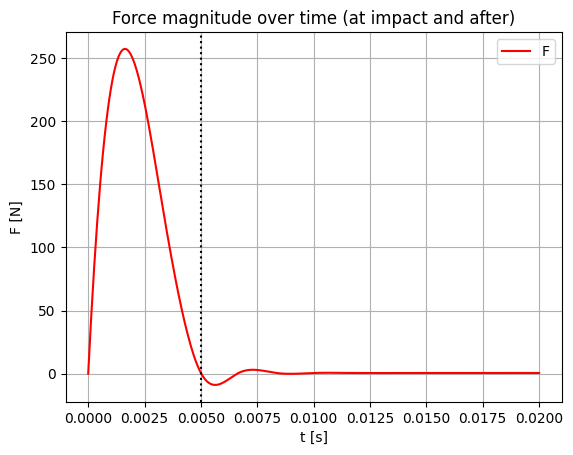

In [75]:
force_smooth   = update_list_smooth(forces_cut_)
spl = make_interp_spline(t_graph_l, force_smooth) 
tf_new = np.linspace(min(t_graph_l), max(t_graph_l), 300)
f_new = spl(tf_new)
plt.plot(tf_new, f_new, color='red', label='F')
cursor(hover=True)
plt.axvline(x = ct_s, color = 'k', linestyle = ':') 
plt.xlabel("t [s]")
plt.ylabel("F [N]")
plt.grid(True)
plt.legend()
plt.title("Force magnitude over time (at impact and after)")
plt.show()

Force $x$ applied to the ball at the moment of the impact 

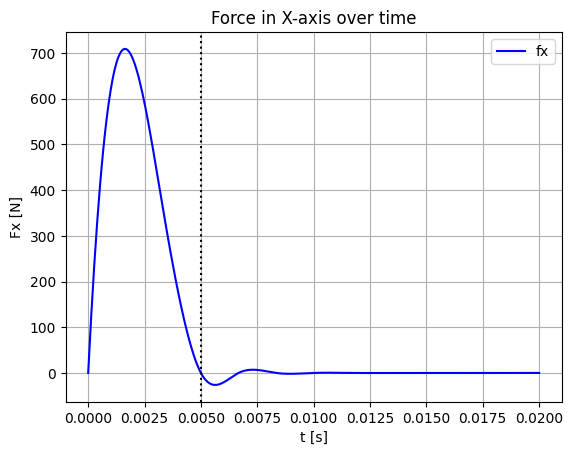

In [76]:
fx_time_smooth = update_list_smooth(fx_time_cut)
spl = make_interp_spline(t_graph_l, fx_time_smooth) 
tfx_new = np.linspace(min(t_graph_l), max(t_graph_l), 300)
fx_new = spl(tfx_new)
plt.plot(tf_new, fx_new, color='blue', label='fx')
cursor(hover=True)
plt.axvline(x = ct_s, color = 'k', linestyle = ':') 
plt.xlabel("t [s]")
plt.ylabel("Fx [N]")
plt.grid(True)
plt.legend()
plt.title("Force in X-axis over time")
plt.show()

Trajectory of the ball seen in side plane

Behaviour of the ball between $x$ and $z$ with respect to time 

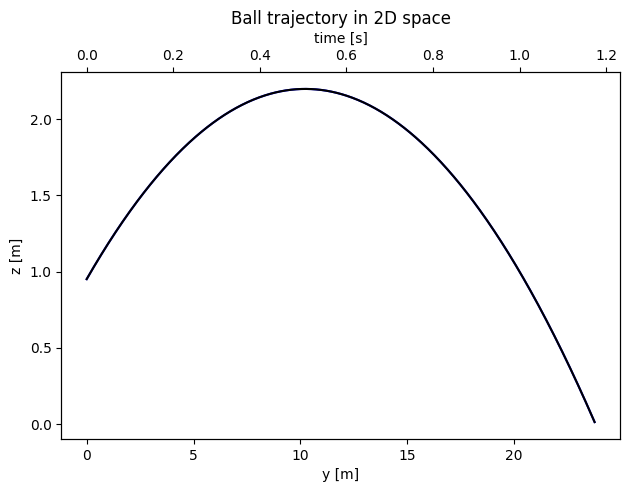

In [77]:
t_ = np.linspace(0, t_zf, len(z_traj))
fig_11, ax_11 = plt.subplots()
ax_11.plot(x_traj, z_traj, color='blue')
plt.xlabel("y [m]") # x simul
plt.ylabel("z [m]")
ax_aa = ax_11.twiny()
ax_aa.plot(t_, z_traj, color='black')
plt.xlabel("time [s]")
fig_11.tight_layout()
plt.title("Ball trajectory in 2D space")
plt.show()

Trajectory of the ball seen in upper plane

Behaviour of the ball between $x$ and $y$ 

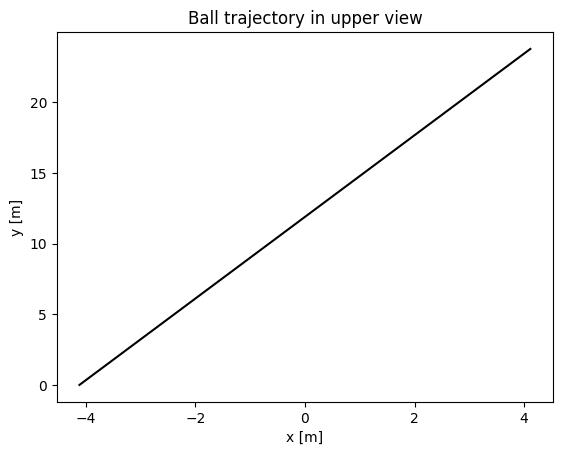

In [78]:
plt.plot(y_traj, x_traj, color='black')
plt.xlabel("x [m]") # y simul
plt.ylabel("y [m]") # x simul
plt.title("Ball trajectory in upper view")
plt.show()


**Half moon range results on the court from the last best variables values**

- varing from integer -$\phi$ to $\phi$

Get the best variable values of the best result

In [79]:
v0_best_p_list = [final_results_p[0][0]]
theta_best_p_list = [final_results_p[0][1]]
print(v0_best_p_list)
print(theta_best_p_list)

[22]
[13]


Get the $\phi$ variation between [-10 to 10]

In [80]:
if phi_p < 0:
    phi_p_list = list(range(mt.floor(phi_p), mt.ceil(-phi_p)+1))
elif phi_p == 0.0 or phi_p == -0.0:
    phi_p = 10
    phi_p_list = list(range(-mt.ceil(phi_p), mt.ceil(phi_p)+1))
else:
    phi_p_list = list(range(-mt.ceil(phi_p), mt.ceil(phi_p)+1))
print(phi_p_list)

[-20, -19, -18, -17, -16, -15, -14, -13, -12, -11, -10, -9, -8, -7, -6, -5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]


Get the results varing the $\phi$ values from -$\phi$ to $\phi$ degrees

In [81]:
half_moon_results_p = calc_f_results(p_origin, phi_p_list, z0, v0_best_p_list, theta_best_p_list)

100%|██████████| 1/1 [00:00<00:00, 23.39it/s]


Check results that go over the net and cut the list to only the values above the ground

In [82]:
checked_results_p_g = check_ball_ground(half_moon_results_p)

100%|██████████| 41/41 [00:00<00:00, 3859.12it/s]

Over the net at *real* y= 11.918 with z= 2.163 m


In [83]:
half_moon_slim_results_p = []

for res in checked_results_p_g:
    
    #if phi is negative
    if res[2] < 0: 
        data_hf = [res[2], max(res[3].T[0]), min(res[3].T[2])] 
    else:
        data_hf = [res[2], max(res[3].T[0]), max(res[3].T[2])] 
    
    half_moon_slim_results_p.append(data_hf) #[phi, max x, max y]
    
print(half_moon_slim_results_p)

[[-20, 23.63490379413294, -12.717401470809715], [-19, 23.781436690612118, -12.303605336277743], [-18, 23.920725531099386, -11.887314873235542], [-17, 24.05272788686462, -11.468656887790845], [-16, 24.177403548711496, -11.047758907221652], [-15, 24.29471453922568, -10.624749141130174], [-14, 24.404625124343028, -10.199756442388956], [-13, 24.50710182423458, -9.772910267891024], [-12, 24.602113423504857, -9.344340639116087], [-11, 24.6896309807003, -8.914178102524719], [-10, 24.769627837125196, -8.482553689792631], [-9, 24.84207962496213, -8.049598877897193], [-8, 24.90696427469468, -7.615445549068233], [-7, 24.964262021829967, -7.180225950615449], [-6, 25.013955412919174, -6.744072654644596], [-5, 25.05602931087398, -6.307118517674744], [-4, 25.090470899577493, -5.869496640168875], [-3, 25.11726968778813, -5.431340325990219], [-2, 25.136417512335434, -4.992783041796596], [-1, 25.147908540606508, -4.553958376385165], [0, 25.151739272322878, -4.115], [1, 25.147908540606508, -3.67604162361

Find each values

In [84]:
phi_values_hm_p = []
x_values_hm_p = []
y_values_hm_p = []
nr_res_p = 0
for res in half_moon_slim_results_p:
    nr_res_p += 1
    phi_values_hm_p.append(res[0]) 
    x_values_hm_p.append(res[1])
    y_values_hm_p.append(res[2])

Display the Half moon range results
- Plot results in respect to $x$, $y$ and $\phi$
- The red dotted line is the limits of the court

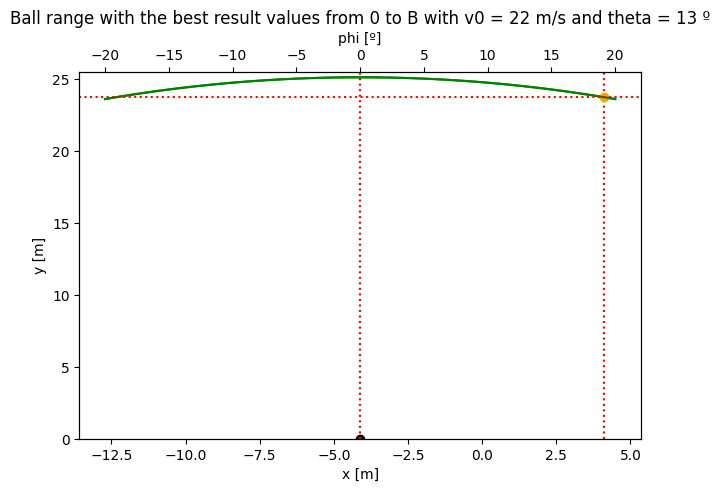

In [92]:
fig, ax1 = plt.subplots()
ax1.plot(y_values_hm_p, x_values_hm_p, color='green')
plt.xlabel("x [m]")
plt.ylabel("y [m]")
plt.axvline(x = 4.115, color = 'r', linestyle = ':') 
plt.axvline(x = -4.115, color = 'r', linestyle = ':') 
plt.scatter([y_fin], [x_fin], color="yellow")
plt.scatter([p_init[1]], [p_init[0]], color="black")
ax2 = ax1.twiny()
ax2.plot(phi_values_hm_p, x_values_hm_p, color='green')
plt.xlabel("phi [º]")
ax2.set_ylim(0, 25.5)
plt.axhline(y = 23.77, color = 'r', linestyle = ':') 
plt.scatter([phi_fin], [x_fin], color="orange")
fig.tight_layout()
plt.title("Ball range with the best result values from 0 to B with v0 = {} m/s and theta = {} º".format(v0_best_p_list[0], theta_best_p_list[0]))
plt.show()

Close up view from the last result

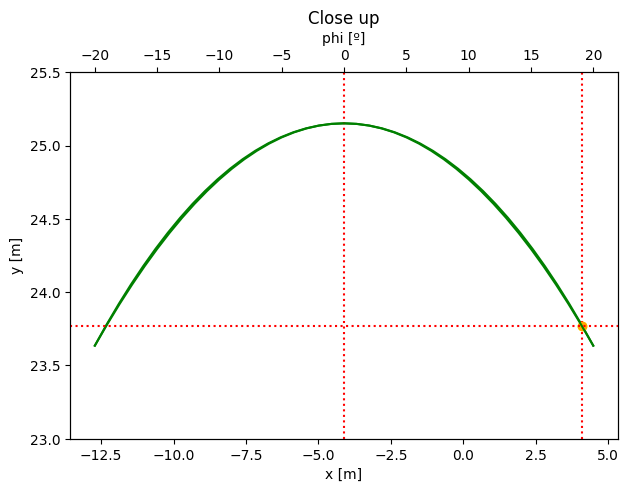

In [93]:
fig, ax1 = plt.subplots()
ax1.plot(y_values_hm_p, x_values_hm_p, color='green')
plt.xlabel("x [m]")
plt.ylabel("y [m]")
plt.axvline(x = 4.115, color = 'r', linestyle = ':') 
plt.axvline(x = -4.115, color = 'r', linestyle = ':') 
plt.scatter([y_fin], [x_fin], color="yellow")
ax2 = ax1.twiny()
ax2.plot(phi_values_hm_p, x_values_hm_p, color='green')
plt.xlabel("phi [º]")
ax2.set_ylim(23, 25.5)
plt.axhline(y = 23.77, color = 'r', linestyle = ':') 
plt.scatter([phi_fin], [x_fin], color="orange")
fig.tight_layout()
plt.title("Close up")
plt.show()

____________________________________________________________________________________________________
____________________________________________________________________________________________________

## Create 2D Animation and export data for 3D Animation

The location $(x,y)$ together given the $x$ and $y$ computed before

In [87]:
coord = list(zip(x_traj, z_traj))

In [88]:
#resolve max values for x and y axes
max_x = max([pt[0] for pt in coord]) + 1
max_y = max([pt[1] for pt in coord]) + 1

#create figure and set limits
fig = plt.figure()
plt.xlim(0, max_x)
plt.ylim(0, max_y)

#create graph
graph_a, = plt.plot([], [], 'o')

#hide figure
plt.close()

2D Animation

In [89]:
valid_types = tuple(range(3))
is_invalid = False
if spin_type in valid_types:
    
    # Increase animation embed limit: 50MB
    mpl.rcParams['animation.embed_limit'] = 50
    
    #it sets point coordinates based an frame number
    def animate(j):
        graph_a.set_data(coord[j][0], coord[j][1])
        
        return graph_a

    #init FuncAnimation
    ani = animation.FuncAnimation(fig, animate, frames=len(coord), interval=200, repeat=False)

    #is needed to make animation available in jupiter / colab
    HTML(ani.to_jshtml())
else:
    is_invalid = True
    print("Invalid spin type")

Data organization

In [90]:
if not is_invalid:
    res = final_results_p[0][3]
    x     = res.T[0]
    v0x   = res.T[1]
    y     = res.T[2]
    v0y   = res.T[3]
    z     = res.T[4]
    v0z   = res.T[5]
    alpha = res.T[6]
    w0x   = res.T[7]
    beta  = res.T[8]
    w0y   = res.T[9]
    gamma = res.T[10]
    w0z   = res.T[11]
    t = np.linspace(0, 5.5, len(x))

Export data to be used in the 3D Animation

In [91]:
# if not is_invalid:
#     np.save('../Main/3DBallTest_e_MAIN', np.array([x, y, z, alpha, beta, gamma, t, v0x, v0y, v0z, w0x, w0y, w0z]))

To see the animation, please download the file "**3DBallTest_e_MAIN.npy**" and run the code from the python script "**vpythonTrajectoryTest_e_MAIN.py.**"